In [4]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

In [5]:
start_date='2014-1-1'
end_date='2017-12-31'

Study of https://github.com/yinanzhu12/Quantopian-notes/blob/master/research%20notes/Pair%20trading%20using%20clustering%20algorithm.ipynb suggest that some stocks have some what close relation, among them is such a pair (RY: Cannadian Royal Bank; BMO: Bank of Montreal):

In [6]:
bmo_price=get_pricing('BMO',start_date=start_date,end_date=end_date,fields='close_price')
ry_price=get_pricing('RY',start_date=start_date,end_date=end_date,fields='close_price')

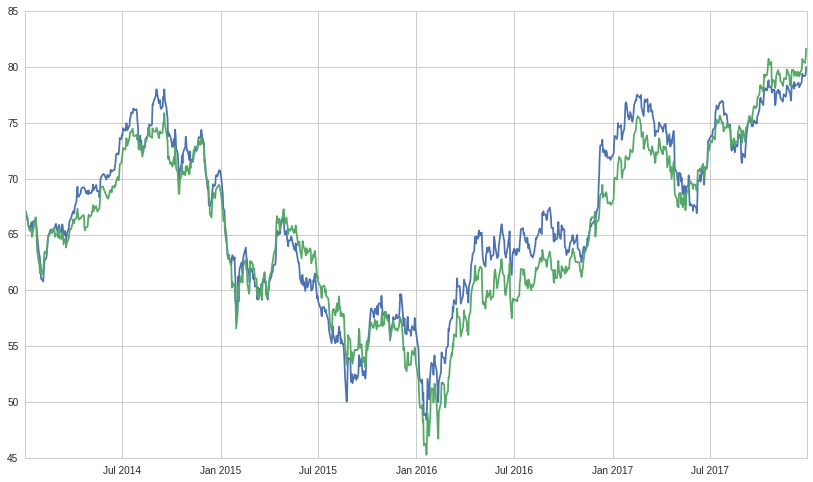

In [7]:
plt.figure()
plt.plot(bmo_price)
plt.plot(ry_price)
plt.show()

augmented dickey fuller test, (with the null hypothesis that there is a unit root), suggest neither price series are stationary

In [5]:
adfuller(bmo_price)

(-0.99706763896481021,
 0.75433230936868023,
 1,
 1005,
 {'1%': -3.4368734638130847,
  '10%': -2.5683035273879358,
  '5%': -2.8644201518188126},
 1954.4904126074325)

In [6]:
adfuller(ry_price)

(-0.57135017812116751,
 0.87732519871982251,
 0,
 1006,
 {'1%': -3.436866962597422,
  '10%': -2.5683020002450507,
  '5%': -2.8644172846037028},
 1964.3714823306539)

Running a Engle-Granger two-step cointegration test, there is certain possibility that they are cointegrated

In [173]:
coint(bmo_price,ry_price)

(-3.1297396374065878,
 0.08248442414629803,
 array([-3.43686047, -2.86441442, -2.56830048]))

In [8]:
x=np.array(bmo_price)
y=np.array(ry_price)

In [9]:
model=sm.OLS(y,x)

In [10]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.205e+06
Date:                Mon, 02 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:07:38   Log-Likelihood:                -2079.9
No. Observations:                1007   AIC:                             4162.
Df Residuals:                    1006   BIC:                             4167.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.9841      0.001   1097.753      0.000         0.982     0.986
==============================================================================
Omnibus:                      199.111   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.298
Skew:                           0.173   Prob(JB):                     1.46e-10
Kurtosis:                       2.020   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

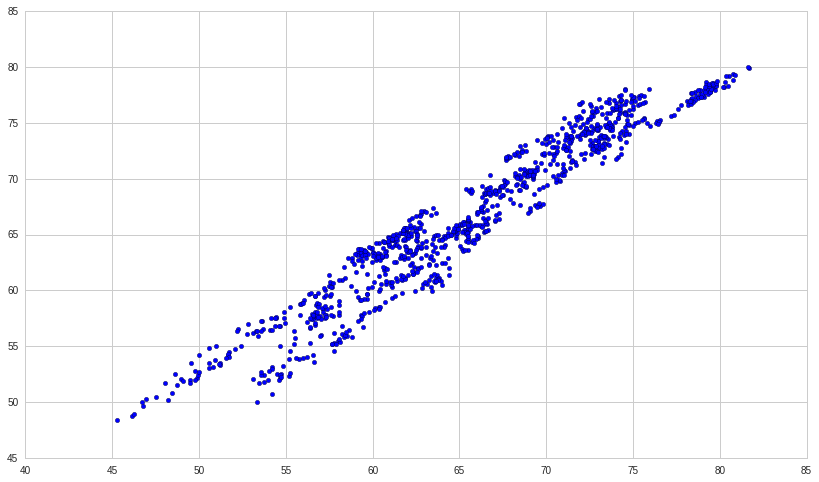

In [33]:
plt.figure()
plt.scatter(ry_price,bmo_price)
plt.show()

we create a spread using result of linear regression

In [19]:
spread=ry_price-0.9841*bmo_price

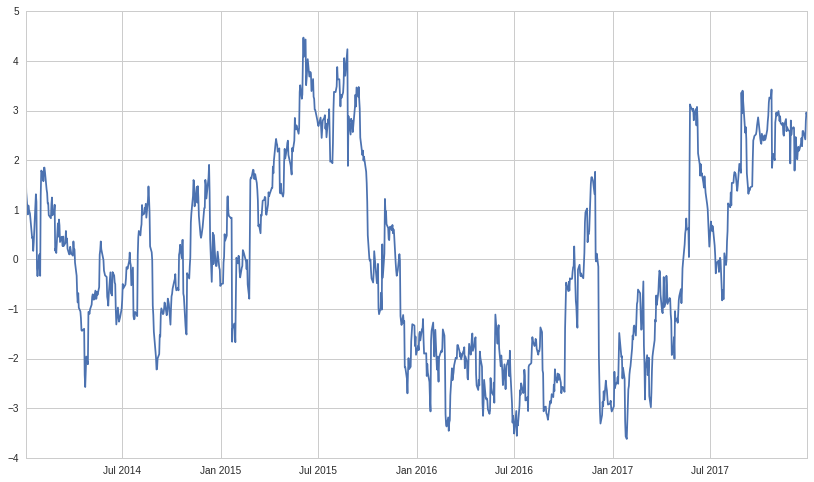

In [20]:
plt.figure()
plt.plot(spread)
plt.show()

Actually we do not need another Dickey-fuller test here because it was already doen in Engle-Granger two-step cointegration test above

In [21]:
adfuller(spread)

(-3.0192223543612258,
 0.033137852508058958,
 0,
 1006,
 {'1%': -3.436866962597422,
  '10%': -2.5683020002450507,
  '5%': -2.8644172846037028},
 832.60767037670985)

A ar(1) model would help us estimate the half life

In [22]:
ar_model=ARIMA(spread,(1,0,0))
ar_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1007
Model:                     ARMA(1, 0)   Log Likelihood                -438.915
Method:                       css-mle   S.D. of innovations              0.374
Date:                Mon, 02 Apr 2018   AIC                            883.830
Time:                        23:18:54   BIC                            898.575
Sample:                    01-02-2014   HQIC                           889.432
                         - 12-29-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2250      0.601      0.374      0.708        -0.953     1.403
ar.L1.y        0.9812      0.006    163.219      0.000         0.969     0.993
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0191           +0.0000j            1.0191            0.0000
-----------------------------------------------------------------------------
"""

In [23]:
hl=np.log(0.5)/np.log(0.9812)
hl

36.521861029050399

compute z_score using rolling mean

In [24]:
w=60
roll_mean=spread.rolling(window=w).mean()
roll_std=spread.rolling(window=w).std()
zscore=(spread-roll_mean)/roll_std

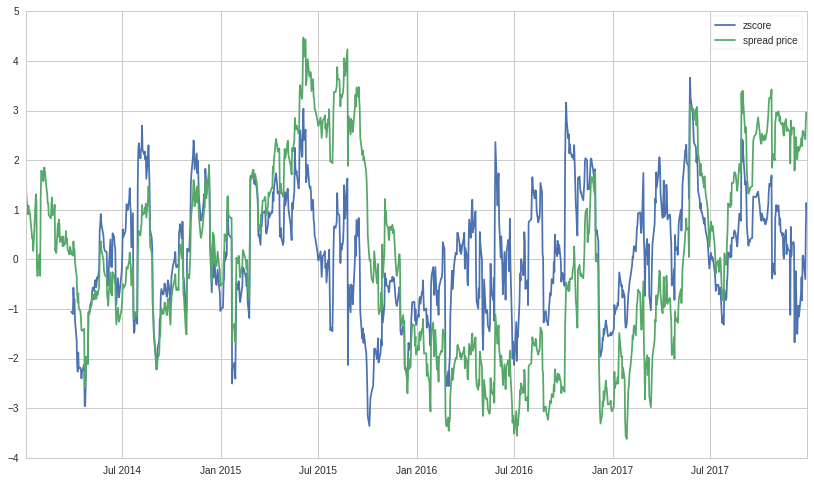

In [26]:
plt.figure()
plt.plot(zscore)
plt.plot(spread)
plt.legend(['zscore','spread price'])
plt.show()

A simple strategy: buy one share when z_score smaller than entry_z, short one when z_score greater than entry_z. Clear the portfolio when zscore surpasses the plus/minus exit_z line

In [27]:
def mean_reverse_1(spread,look_back=60,entry_z=1,exit_z=0):
    share=0
    cash=0
    roll_mean=spread.rolling(window=look_back).mean()
    roll_std=spread.rolling(window=look_back).std()
    zscore=(spread-roll_mean)/roll_std
    capital=[0]
    for index in spread.index:
        if not np.isnan(zscore[index]):
            if share==0:
                capital.append(capital[-1])
                if zscore[index]>entry_z:
                    share=-1
                    print('sell at price '+str(spread[index]))
                    cash=cash-share*spread[index]
                elif zscore[index]<-entry_z:
                    share=1
                    print('buy at price '+str(spread[index]))
                    cash=cash-share*spread[index]
            elif share>0:
                capital.append(cash+share*spread[index])
                if zscore[index]>-exit_z:
                    print('sell at price '+str(spread[index]))
                    share=0
                    cash=capital[-1]
                if zscore[index]>entry_z:
                    print('sell at price '+str(spread[index]))
                    share=-1
                    cash=cash-share*spread[index]
            else:
                capital.append(cash+share*spread[index])
                if zscore[index]<exit_z:
                    print('buy at price '+str(spread[index]))
                    share=0
                    cash=capital[-1]
                if zscore[index]<-entry_z:
                    print('buy at price '+str(spread[index]))
                    share=1
                    cash=cash-share*spread[index]
    return capital

In [28]:
cap=mean_reverse_1(spread,look_back=60)

buy at price 0.116396
sell at price 0.096765
sell at price -0.157659
buy at price -1.136989
buy at price -1.136989
sell at price 0.083772
sell at price 0.083772
buy at price -0.930788
buy at price -1.121424
sell at price -0.401844
buy at price -1.477057
sell at price -0.276614
sell at price 0.744306
buy at price -0.4526075
buy at price -0.535393
sell at price 0.507844
sell at price 1.255692
buy at price -1.65989
buy at price -1.65989
sell at price 0.325766
sell at price 1.605959
buy at price 2.687941
buy at price 1.969764
sell at price 3.021831
sell at price 3.877856
buy at price 3.085011
sell at price 4.057822
buy at price 1.885244
buy at price 1.885244
sell at price 3.064273
buy at price 2.456198
sell at price -1.411082
buy at price -3.119668
sell at price -1.983967
sell at price -1.595773
buy at price -2.3180769
buy at price -2.900103
sell at price -1.7987345
sell at price -1.7987345
buy at price -2.2604495
buy at price -2.903899
sell at price -2.4982019
sell at price -1.787187
buy 

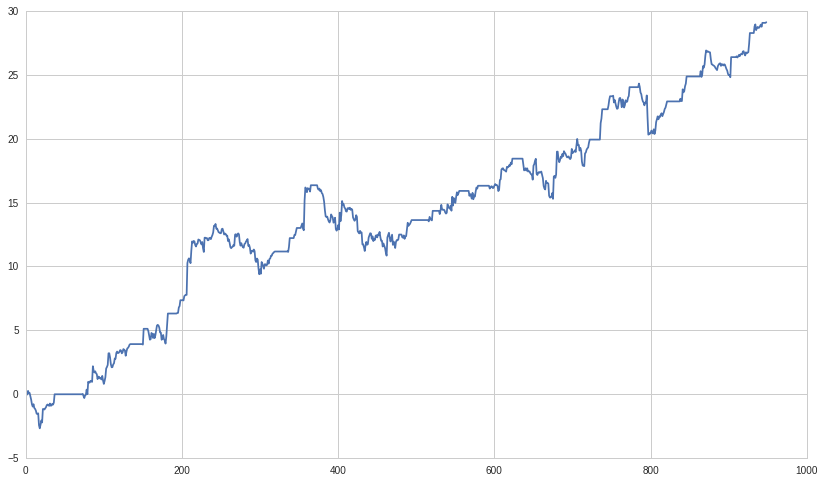

In [29]:
plt.figure()
plt.plot(cap)
plt.show()

This result doesn't mean much as it is a result of look ahead bias, now we use only first 500 days result to build trading strategy

In [30]:
x=np.array(bmo_price)[:500]
y=np.array(ry_price)[:500]

In [12]:
model=sm.OLS(y,x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.495e+05
Date:                Mon, 02 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:07:57   Log-Likelihood:                -935.29
No. Observations:                 500   AIC:                             1873.
Df Residuals:                     499   BIC:                             1877.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.9931      0.001    921.681      0.000         0.991     0.995
==============================================================================
Omnibus:                       24.516   Durbin-Watson:                   0.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.906
Skew:                           0.357   Prob(JB):                     0.000129
Kurtosis:                       2.409   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
spread=ry_price-0.9931*bmo_price

In [34]:
adfuller(spread[:500])

(-2.2654003538014837,
 0.18336991006807207,
 6,
 493,
 {'1%': -3.4436840273842058,
  '10%': -2.5699020441557052,
  '5%': -2.8674204319994674},
 420.37994559035849)

In [35]:
cap_2=mean_reverse_1(spread)

buy at price -0.481564
sell at price -0.518385
sell at price -0.832569
buy at price -1.823599
buy at price -1.823599
sell at price -0.591948
sell at price -0.591948
buy at price -1.620908
buy at price -1.811184
sell at price -1.102298
buy at price -2.140987
sell at price -0.929474
sell at price 0.102246
buy at price -1.0652825
buy at price -1.171963
sell at price -0.096596
sell at price 0.680772
buy at price -2.22599
buy at price -2.22599
sell at price -0.220894
sell at price 1.047869
buy at price 2.13296
buy at price 1.466124
sell at price 2.517021
sell at price 3.375296
buy at price 2.578401
sell at price 3.566602
buy at price 1.406804
buy at price 1.406804
sell at price 2.592043
buy at price 1.701565
sell at price -1.897262
buy at price -3.600988
sell at price -2.513797
sell at price -2.057439
buy at price -2.8959579
buy at price -3.214122
sell at price -2.442397
buy at price -3.474573
sell at price -2.3796395
sell at price -1.688469
buy at price -2.740741
buy at price -3.456409
sel

This strategy is still profitable even after 500 days

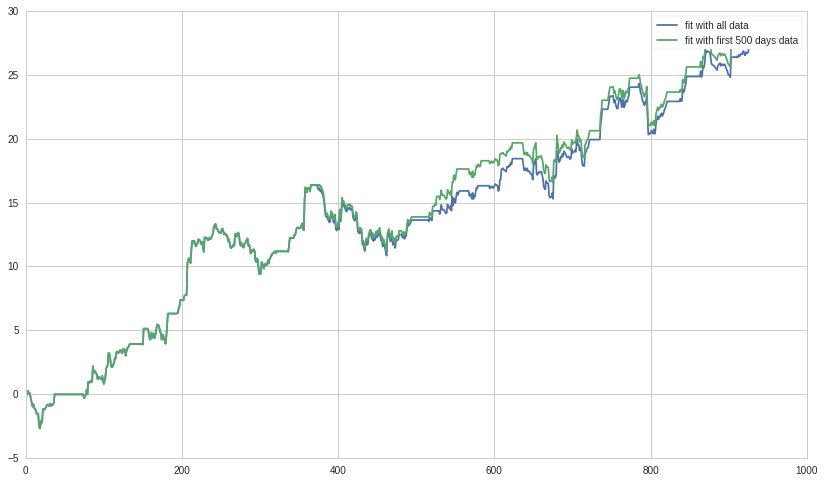

In [36]:
plt.figure()
plt.plot(cap)
plt.plot(cap_2)
plt.legend(['fit with all data','fit with first 500 days data'])
plt.show()

A more apropriate strategy is instead of buying 1 share every time, keep investing a certain proportion of capital in the portfolio (leverage). We implement the strategy in quantopian environment and test the result (all with leverage 1)

The algorithm with look ahead bias:

100% Time: 0:00:00|###########################################################|


Start date,2014-01-06
End date,2017-12-29
Total months,47
,Backtest
Annual return,3.4%
Cumulative returns,14.4%
Annual volatility,3.9%
Sharpe ratio,0.88
Calmar ratio,0.64
Stability,0.90
Max drawdown,-5.4%


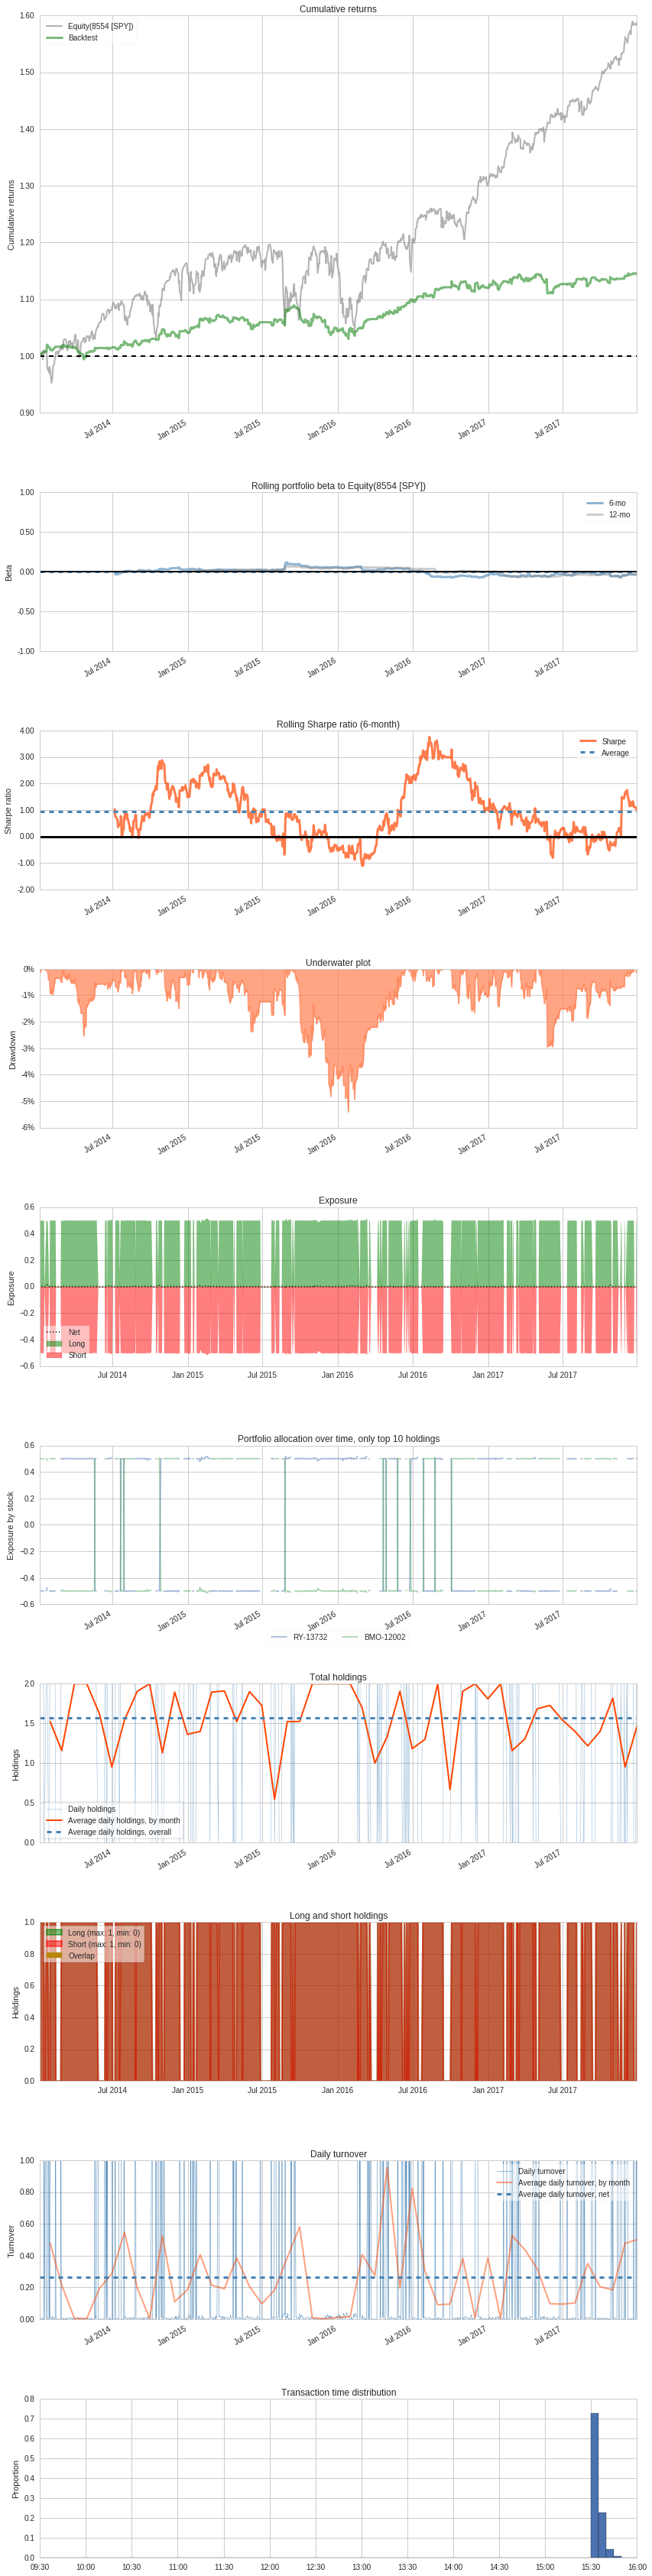

In [37]:
bt = get_backtest('5ac2bb09d9f2f2403ef1a3f6')
bt.create_simple_tear_sheet()

The one with 'half-look-ahead' bias (using the first half of data to determine beta)

100% Time: 0:00:00|###########################################################|


Start date,2014-01-06
End date,2017-12-29
Total months,47
,Backtest
Annual return,3.7%
Cumulative returns,15.4%
Annual volatility,3.9%
Sharpe ratio,0.93
Calmar ratio,0.68
Stability,0.90
Max drawdown,-5.4%


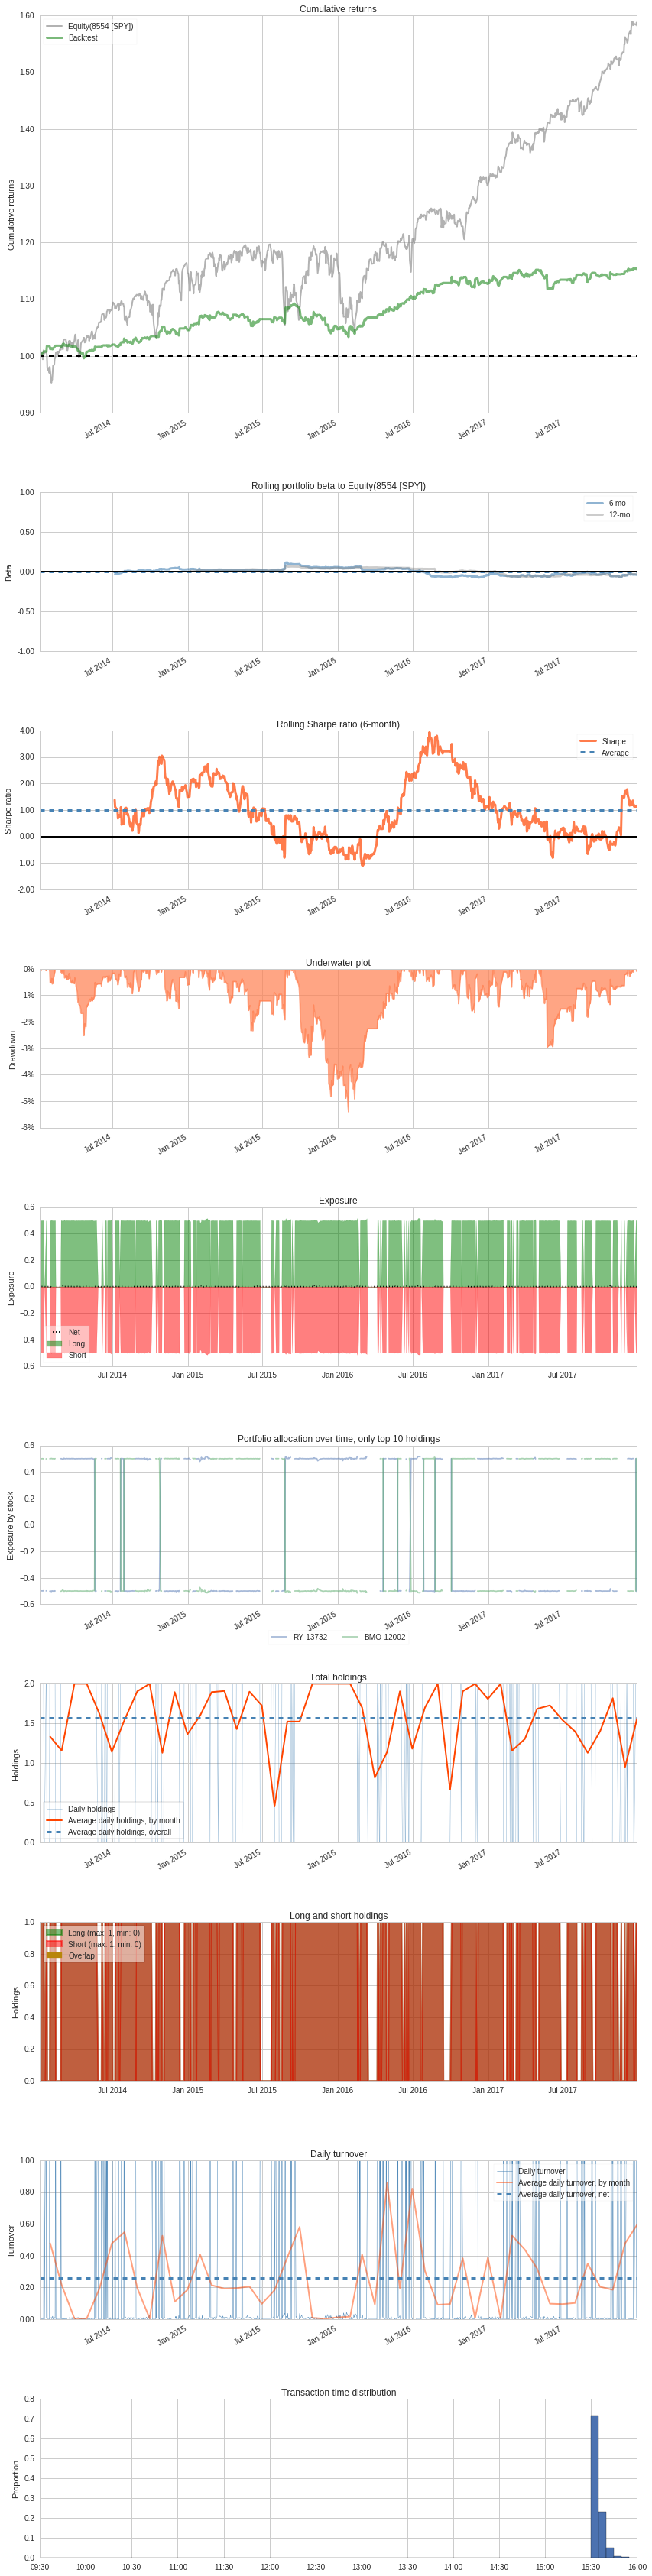

In [14]:
bt=get_backtest('5ac2b9d9d9f2f2403ef1a3ca')
bt.create_simple_tear_sheet()

# Mean reverse of a spread with dynamic ratio

In order to achieve a strategy without any look ahead bias, I propose to adjust the spread online using moving regression result which involves only the most recent n-days' data (n is adjustable), and to rebalance the portfolio constantly to meet the new spread. This is inspired by https://www.quantopian.com/lectures/example-pairs-trading-algorithm. After some (but not too many) parameter tunning, the best backtest is below, beta is still great but there are several unpleasant drawdowns

100% Time: 0:00:01|###########################################################|


Start date,2014-01-06
End date,2017-12-29
Total months,47
,Backtest
Annual return,3.8%
Cumulative returns,15.9%
Annual volatility,3.9%
Sharpe ratio,0.96
Calmar ratio,0.70
Stability,0.90
Max drawdown,-5.4%


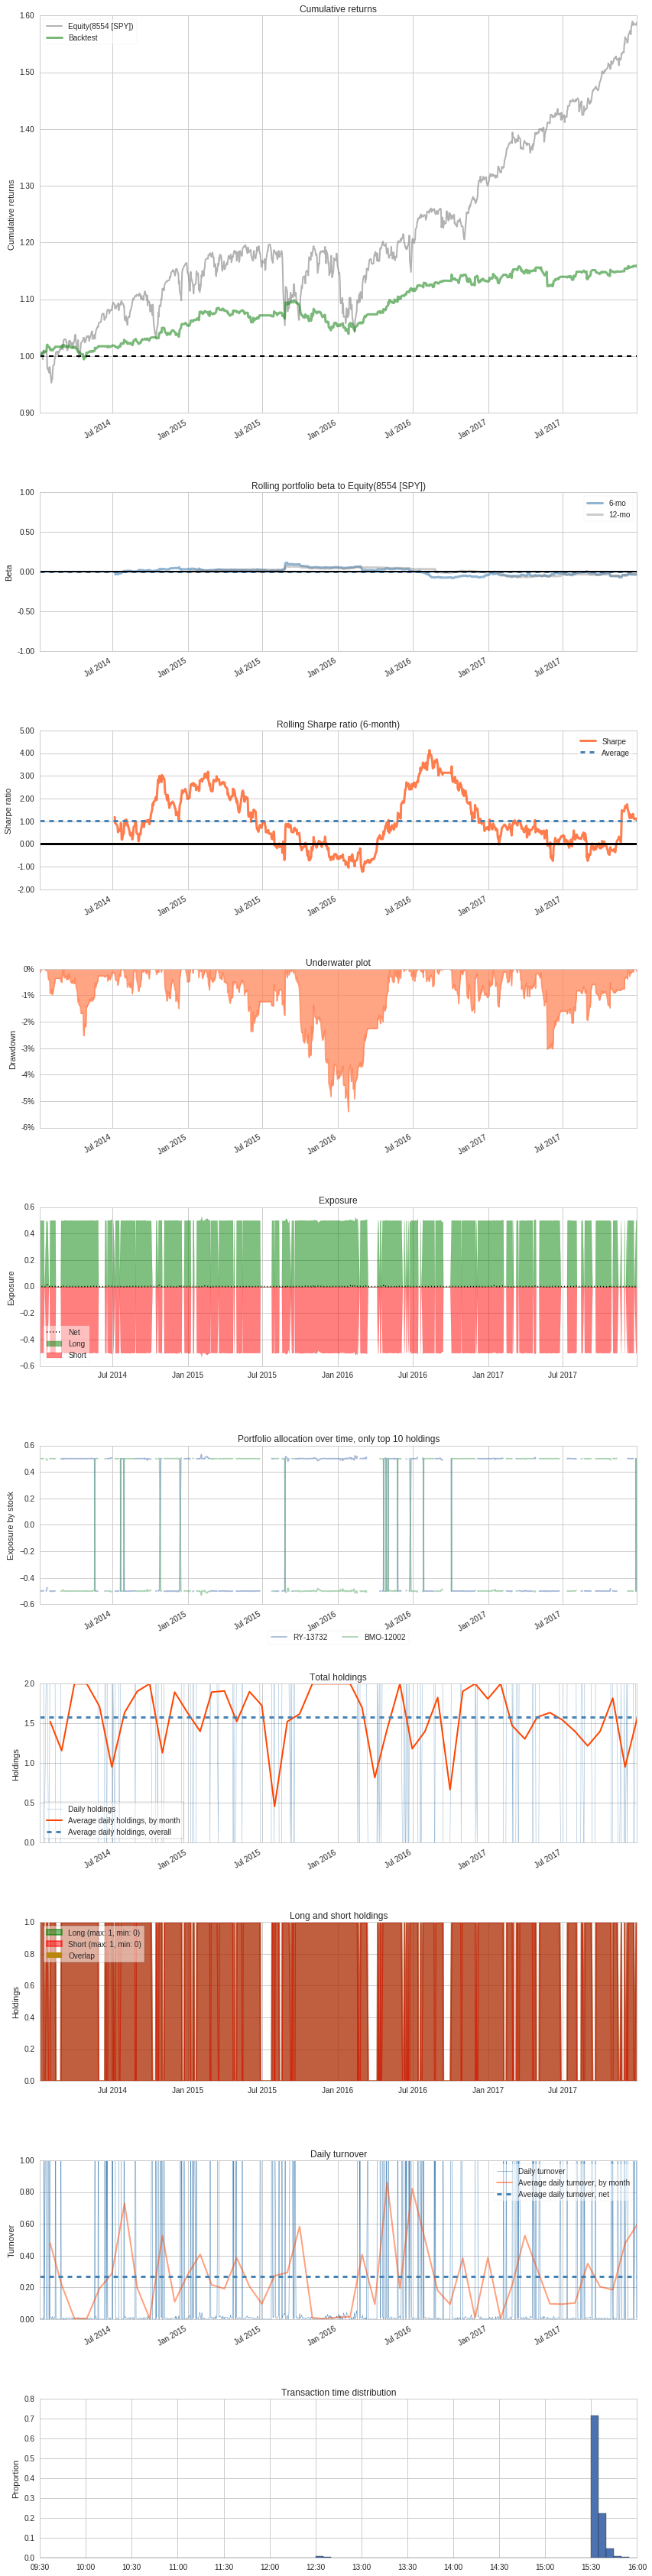

In [13]:
bt=get_backtest('5ac2b9a0b9e42141dcdee01c')
bt.create_simple_tear_sheet()